In [12]:
import pandas as pd
data=pd.read_csv(r'germany_hourly_generation_2020_2025.csv', sep=";")
print(data['Nuclear [MWh] Calculated resolutions'].isnull().sum())
print(data.columns)
data["Start date"] = pd.to_datetime(data["Start date"], format='%b %d, %Y %I:%M %p')
data = data.sort_values("Start date")
data = data.rename(columns={"Start date":"timestamp"})
data=data.drop('End date', axis=1)

0
Index(['Start date', 'End date', 'Biomass [MWh] Calculated resolutions',
       'Hydropower [MWh] Calculated resolutions',
       'Wind offshore [MWh] Calculated resolutions',
       'Wind onshore [MWh] Calculated resolutions',
       'Photovoltaics [MWh] Calculated resolutions',
       'Other renewable [MWh] Calculated resolutions',
       'Nuclear [MWh] Calculated resolutions',
       'Lignite [MWh] Calculated resolutions',
       'Hard coal [MWh] Calculated resolutions',
       'Fossil gas [MWh] Calculated resolutions',
       'Hydro pumped storage [MWh] Calculated resolutions',
       'Other conventional [MWh] Calculated resolutions'],
      dtype='object')


In [16]:
energy_cols = data.columns.drop("timestamp")
for col in energy_cols:
    data[col] = pd.to_numeric(data[col], errors="coerce")
data["total_generation"] = data[energy_cols].sum(axis=1)

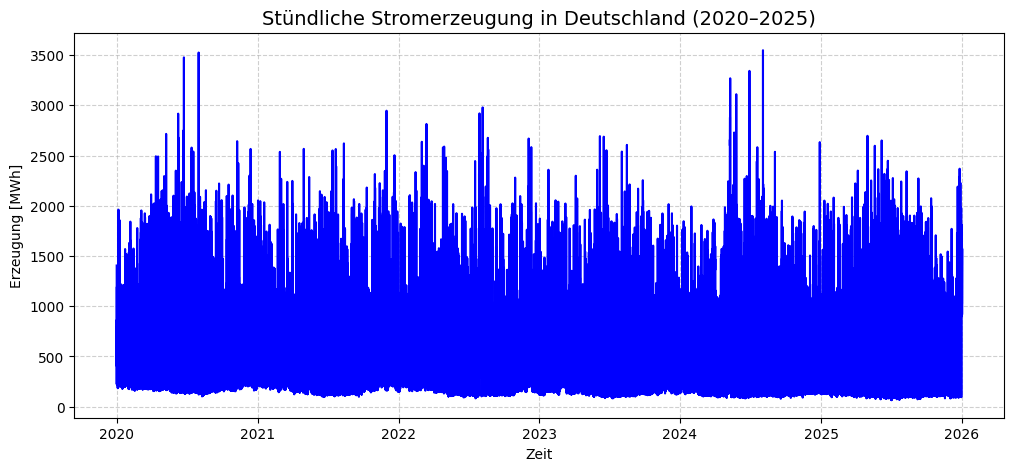

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(data["timestamp"], data["total_generation"], label="Gesamtstromerzeugung", color="blue")
plt.title("Stündliche Stromerzeugung in Deutschland (2020–2025)", fontsize=14)
plt.xlabel("Zeit")
plt.ylabel("Erzeugung [MWh]")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [18]:
data = data.set_index("timestamp")
daily = data["total_generation"].resample("D").mean()

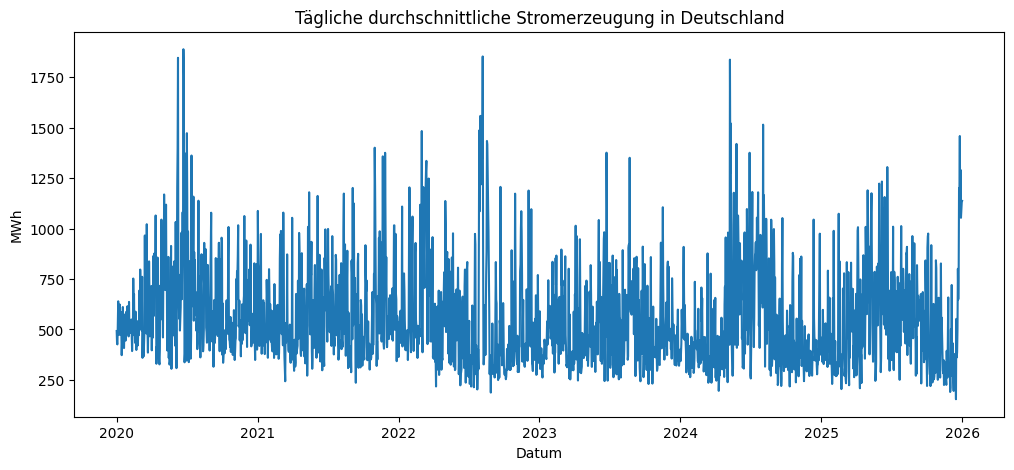

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(daily)
plt.title("Tägliche durchschnittliche Stromerzeugung in Deutschland")
plt.xlabel("Datum")
plt.ylabel("MWh")
plt.show()

In [20]:
train = daily[:-180]
test = daily[-180:]
window = 7
train_ma = train.rolling(window=window).mean()
last_ma = train_ma.dropna().iloc[-1]
predictions = [last_ma] * len(test)

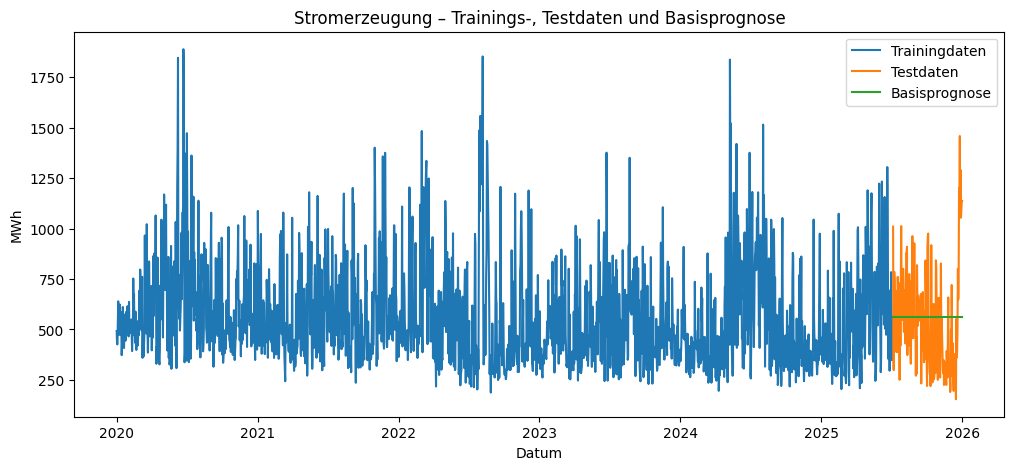

In [21]:
plt.figure(figsize=(12,5))
plt.plot(train.index, train, label="Trainingdaten")
plt.plot(test.index, test, label="Testdaten")
plt.plot(test.index, predictions, label="Basisprognose")
plt.title("Stromerzeugung – Trainings-, Testdaten und Basisprognose")
plt.xlabel("Datum")
plt.ylabel("MWh")
plt.legend()
plt.show()

In [23]:
split = int(len(daily) * 0.8)
train = daily[:split]
test = daily[split:]
print(len(train), len(test))

1754 439


In [24]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(train)

print("ADF Statistic:", result[0])
print("p-value:", result[1])


ADF Statistic: -6.843042781766868
p-value: 1.7711461275575962e-09


<Figure size 1200x500 with 0 Axes>

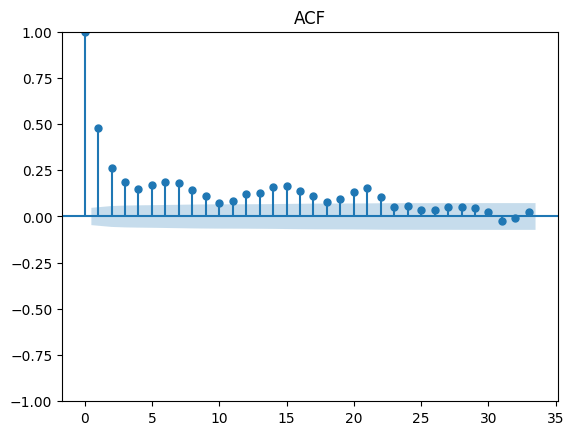

<Figure size 1200x500 with 0 Axes>

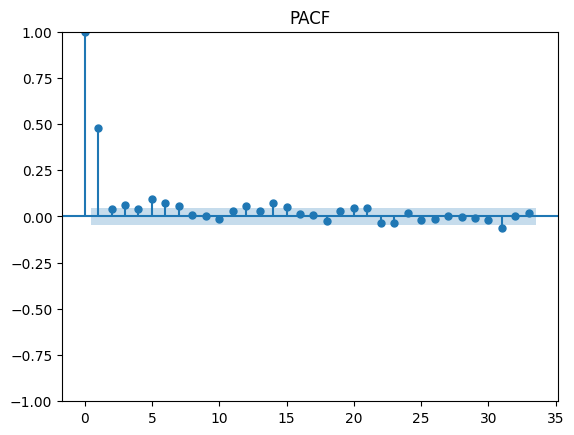

In [25]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plot_acf(train)
plt.title("ACF")
plt.show()

plt.figure(figsize=(12,5))
plot_pacf(train)
plt.title("PACF")
plt.show()

In [27]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train, order=(5,0,2))
model_fit = model.fit()

print(model_fit.summary())

C:\Users\hp\PycharmProjects\PythonProject\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\hp\PycharmProjects\PythonProject\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:       total_generation   No. Observations:                 1754
Model:                 ARIMA(5, 0, 2)   Log Likelihood              -11891.499
Date:                Thu, 05 Feb 2026   AIC                          23800.998
Time:                        20:04:31   BIC                          23850.225
Sample:                    01-01-2020   HQIC                         23819.193
                         - 10-19-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        567.9787     23.847     23.817      0.000     521.239     614.718
ar.L1          0.9069      0.455      1.992      0.046       0.014       1.799
ar.L2          0.1370      0.611      0.224      0.8

In [28]:
model2 = ARIMA(train, order=(1,0,1))
fit2 = model2.fit()

print(fit2.summary())


                               SARIMAX Results                                
Dep. Variable:       total_generation   No. Observations:                 1754
Model:                 ARIMA(1, 0, 1)   Log Likelihood              -11913.265
Date:                Thu, 05 Feb 2026   AIC                          23834.531
Time:                        20:07:29   BIC                          23856.410
Sample:                    01-01-2020   HQIC                         23842.618
                         - 10-19-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        567.9875     13.170     43.127      0.000     542.175     593.800
ar.L1          0.5672      0.032     17.599      0.000       0.504       0.630
ma.L1         -0.1147      0.040     -2.838      0.0

In [29]:
predictions = fit2.forecast(steps=len(test))
from sklearn.metrics import mean_squared_error
import numpy as np

rmse = np.sqrt(mean_squared_error(test, predictions))
print("RMSE:", rmse)

RMSE: 244.97371720389992


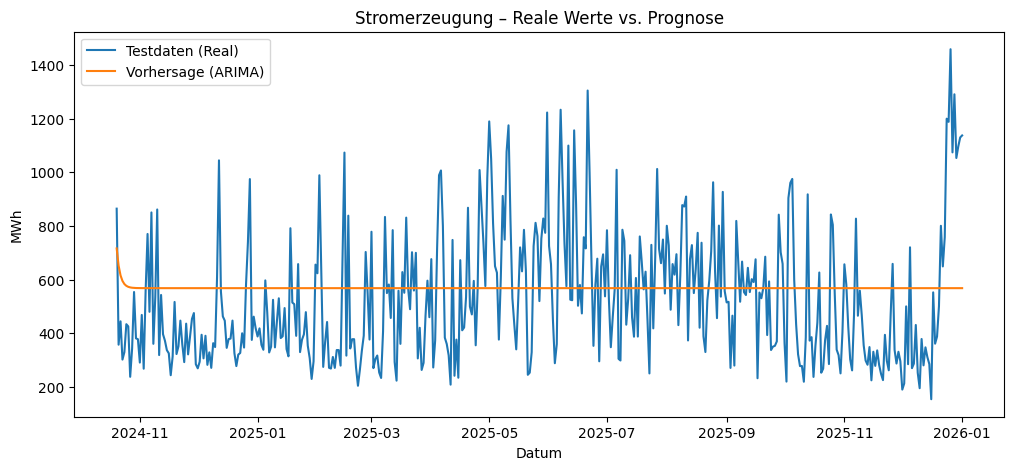

In [30]:
plt.figure(figsize=(12,5))
plt.plot(test.index, test, label="Testdaten (Real)")
plt.plot(test.index, predictions, label="Vorhersage (ARIMA)")
plt.title("Stromerzeugung – Reale Werte vs. Prognose")
plt.xlabel("Datum")
plt.ylabel("MWh")
plt.legend()
plt.show()

# Statistische Analyse der Energieerzeugung in Deutschland (2020–2025)

Dieses Projekt umfasst eine detaillierte statistische Untersuchung der stündlichen Stromerzeugung in Deutschland für den Zeitraum von 2020 bis 2025. Ziel ist es, Trends, Saisonalitäten und die Stationarität der Zeitreihen zu analysieren.

## Projektschwerpunkte
- **Datenbereinigung:** Verarbeitung von Zeitstempeln und Behandlung fehlender Werte in verschiedenen Energiequellen (Wind, Solar, Kernkraft, Fossile Brennstoffe usw.).
- **Zeitreihenanalyse:** Untersuchung der täglichen Durchschnittswerte und gleitenden Mittelwerte.
- **Statistische Tests:** Durchführung des Augmented Dickey-Fuller (ADF) Tests zur Überprüfung der Stationarität.

## Analyseergebnisse

### 1. Datenübersicht
Der Datensatz enthält stündliche Erzeugungsdaten für alle relevanten Energieträger in Deutschland. Die Daten wurden auf tägliche Mittelwerte resampled, um langfristige Trends besser sichtbar zu machen.

### 2. Stationaritätsprüfung (ADF-Test)
Um die Eignung der Daten für Zeitreihenmodelle zu prüfen, wurde der ADF-Test angewendet:
- **ADF-Statistik:** -6.84
- **p-Wert:** 1.77e-09
**Fazit:** Da der p-Wert deutlich unter dem Signifikanzniveau von 0.05 liegt, kann die Nullhypothese abgelehnt werden. Die Zeitreihe ist **stationär**.

### 3. Autokorrelation
Die ACF- und PACF-Diagramme zeigen die Korrelationsstruktur der Daten über verschiedene Zeitverzögerungen (Lags) hinweg, was für zukünftige Prognosemodelle (wie ARIMA) essentiell ist.

## Verwendete Bibliotheken
- **Pandas:** Datenmanipulation
- **Matplotlib:** Visualisierung
- **Statsmodels:** Statistische Modellierung und Tests

## Installation
```bash
pip install pandas matplotlib statsmodels